In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F

import torch.optim as optim
from torchvision import datasets, transforms
import argparse
import os

In [2]:
#数据加载
from torchvision.datasets import ImageFolder
simple_transform = transforms.Compose([transforms.Resize((256,256))
                                       ,transforms.ToTensor()
                                       ,transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
                                      ])
train_data = ImageFolder('./DogVsCatData/train',simple_transform)
print(train_data.class_to_idx)
print(train_data.classes) 

{'cat': 0, 'dog': 1}
['cat', 'dog']


In [15]:
#绘制图片
import numpy as np
import matplotlib.pyplot as plt
def imshow(inp,cmap=None):
    inp = inp.numpy().transpose((1,2,0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp,cmap)

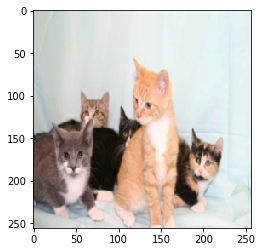

In [62]:
imshow(train_data[99][0])

In [112]:
#定义模型
class DogCat_Net(nn.Module):
    def __init__(self):
        super(DogCat_Net,self).__init__()
        #RGB对应Channel=3，定义16个卷积核，卷积核大小为7，膨胀率为2
        self.conv1 = nn.Conv2d(3, 4, kernel_size=7,dilation=2)
        self.conv2 = nn.Conv2d(4, 16, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(55696, 1000)
        self.fc2 = nn.Linear(1000,50)
        self.fc3 = nn.Linear(50, 2)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 55696)
        x = F.relu(self.fc1(x))
        x = F.dropout(x)
        x = F.relu(self.fc2(x))
        x = F.dropout(x)
        x = self.fc3(x)
        return F.log_softmax(x,dim=1)

In [2]:
def train(args, model, device, dataloader_kwargs):
    #手动设置随机种子
    torch.manual_seed(args.get("seed"))
    #加载训练数据
    train_loader = torch.utils.data.DataLoader(args.get("train_data"),batch_size=args.get("batch_size"),num_workers=6,shuffle=True,**dataloader_kwargs)
    
    #使用随机梯度下降进行优化
    optimizer = optim.SGD(model.parameters(), lr=args.get("lr"), momentum=args.get("momentum"))
    #开始训练，训练epoches次
    for epoch in range(1, args.get("epochs") + 1):
        train_epoch(epoch, args, model, device, train_loader, optimizer)



def train_epoch(epoch, args, model, device, data_loader, optimizer):
    #模型转换为训练模式
    model.train()
    pid = os.getpid()
    for batch_idx, (data, target) in enumerate(data_loader):
        #优化器梯度置0
        optimizer.zero_grad()
        #输入特征预测值
        output = model(data.to(device))
        #预测值与标准值计算损失
        loss = F.nll_loss(output, target.to(device))
        #计算梯度
        loss.backward()
        #更新梯度
        optimizer.step()
        #每10步打印一下日志
        if batch_idx % 10 == 0:
            print('{}\tTrain Epoch: {} [{}/{} ({:.2f}%)]\tLoss: {:.12f}'.format(pid, epoch, batch_idx * len(data), len(data_loader.dataset),
                                                                               100. * batch_idx / len(data_loader), loss.item()))

In [117]:
#超参数及默认值
args={
    'batch_size':128,
    'epochs':50,
    'lr':0.01,
    'momentum':0.9,
    'seed':1,
    'log_interval':30,
    'train_data':train_data
}
use_cuda=True if torch.cuda.is_available() else False

if __name__=="__main__":
    #运行时设备
    device = torch.device("cuda" if use_cuda else "cpu")
    torch.cuda.empty_cache()
    #使用固定缓冲区
    dataloader_kwargs = {'pin_memory': True} if use_cuda else {}
    #模型拷贝到设备
    model = DogCat_Net().to(device)
    train(args, model,device, dataloader_kwargs)

12688	Train Epoch: 1 [0/22587 (0.00%)]	Loss: 0.695126771927
12688	Train Epoch: 1 [1280/22587 (5.65%)]	Loss: 0.702491402626
12688	Train Epoch: 1 [2560/22587 (11.30%)]	Loss: 0.704758763313
12688	Train Epoch: 1 [3840/22587 (16.95%)]	Loss: 0.694592356682
12688	Train Epoch: 1 [5120/22587 (22.60%)]	Loss: 0.655581057072
12688	Train Epoch: 1 [6400/22587 (28.25%)]	Loss: 0.696196556091
12688	Train Epoch: 1 [7680/22587 (33.90%)]	Loss: 0.672302484512
12688	Train Epoch: 1 [8960/22587 (39.55%)]	Loss: 0.688901424408
12688	Train Epoch: 1 [10240/22587 (45.20%)]	Loss: 0.667270362377
12688	Train Epoch: 1 [11520/22587 (50.85%)]	Loss: 0.674867093563
12688	Train Epoch: 1 [12800/22587 (56.50%)]	Loss: 0.680688261986
12688	Train Epoch: 1 [14080/22587 (62.15%)]	Loss: 0.703976392746
12688	Train Epoch: 1 [15360/22587 (67.80%)]	Loss: 0.652511894703
12688	Train Epoch: 1 [16640/22587 (73.45%)]	Loss: 0.664961934090
12688	Train Epoch: 1 [17920/22587 (79.10%)]	Loss: 0.674314498901
12688	Train Epoch: 1 [19200/22587 (84.

12688	Train Epoch: 15 [1280/22587 (5.65%)]	Loss: 0.164904400706
12688	Train Epoch: 15 [2560/22587 (11.30%)]	Loss: 0.181930035353
12688	Train Epoch: 15 [3840/22587 (16.95%)]	Loss: 0.204812988639
12688	Train Epoch: 15 [5120/22587 (22.60%)]	Loss: 0.107052884996
12688	Train Epoch: 15 [6400/22587 (28.25%)]	Loss: 0.198414921761
12688	Train Epoch: 15 [7680/22587 (33.90%)]	Loss: 0.215372070670
12688	Train Epoch: 15 [8960/22587 (39.55%)]	Loss: 0.228171050549
12688	Train Epoch: 15 [10240/22587 (45.20%)]	Loss: 0.193253591657
12688	Train Epoch: 15 [11520/22587 (50.85%)]	Loss: 0.171914771199
12688	Train Epoch: 15 [12800/22587 (56.50%)]	Loss: 0.244103372097
12688	Train Epoch: 15 [14080/22587 (62.15%)]	Loss: 0.187360927463
12688	Train Epoch: 15 [15360/22587 (67.80%)]	Loss: 0.248046278954
12688	Train Epoch: 15 [16640/22587 (73.45%)]	Loss: 0.230955913663
12688	Train Epoch: 15 [17920/22587 (79.10%)]	Loss: 0.280533850193
12688	Train Epoch: 15 [19200/22587 (84.75%)]	Loss: 0.228671476245
12688	Train Epoch:

12688	Train Epoch: 28 [21760/22587 (96.05%)]	Loss: 0.051284428686
12688	Train Epoch: 29 [0/22587 (0.00%)]	Loss: 0.073863729835
12688	Train Epoch: 29 [1280/22587 (5.65%)]	Loss: 0.104968056083
12688	Train Epoch: 29 [2560/22587 (11.30%)]	Loss: 0.105746723711
12688	Train Epoch: 29 [3840/22587 (16.95%)]	Loss: 0.045111801475
12688	Train Epoch: 29 [5120/22587 (22.60%)]	Loss: 0.166889756918
12688	Train Epoch: 29 [6400/22587 (28.25%)]	Loss: 0.065799176693
12688	Train Epoch: 29 [7680/22587 (33.90%)]	Loss: 0.030469950289
12688	Train Epoch: 29 [8960/22587 (39.55%)]	Loss: 0.057463191450
12688	Train Epoch: 29 [10240/22587 (45.20%)]	Loss: 0.052094910294
12688	Train Epoch: 29 [11520/22587 (50.85%)]	Loss: 0.093685895205
12688	Train Epoch: 29 [12800/22587 (56.50%)]	Loss: 0.060015693307
12688	Train Epoch: 29 [14080/22587 (62.15%)]	Loss: 0.045133128762
12688	Train Epoch: 29 [15360/22587 (67.80%)]	Loss: 0.024006109685
12688	Train Epoch: 29 [16640/22587 (73.45%)]	Loss: 0.051949366927
12688	Train Epoch: 29 [

12688	Train Epoch: 42 [19200/22587 (84.75%)]	Loss: 0.009461257607
12688	Train Epoch: 42 [20480/22587 (90.40%)]	Loss: 0.014295623638
12688	Train Epoch: 42 [21760/22587 (96.05%)]	Loss: 0.019588613883
12688	Train Epoch: 43 [0/22587 (0.00%)]	Loss: 0.031013010070
12688	Train Epoch: 43 [1280/22587 (5.65%)]	Loss: 0.020429300144
12688	Train Epoch: 43 [2560/22587 (11.30%)]	Loss: 0.065325602889
12688	Train Epoch: 43 [3840/22587 (16.95%)]	Loss: 0.051121816039
12688	Train Epoch: 43 [5120/22587 (22.60%)]	Loss: 0.033791188151
12688	Train Epoch: 43 [6400/22587 (28.25%)]	Loss: 0.051551859826
12688	Train Epoch: 43 [7680/22587 (33.90%)]	Loss: 0.019295576960
12688	Train Epoch: 43 [8960/22587 (39.55%)]	Loss: 0.025700973347
12688	Train Epoch: 43 [10240/22587 (45.20%)]	Loss: 0.028377896175
12688	Train Epoch: 43 [11520/22587 (50.85%)]	Loss: 0.057907655835
12688	Train Epoch: 43 [12800/22587 (56.50%)]	Loss: 0.027969669551
12688	Train Epoch: 43 [14080/22587 (62.15%)]	Loss: 0.054142005742
12688	Train Epoch: 43 [

In [203]:
model

DogCat_Net(
  (conv1): Conv2d(3, 4, kernel_size=(7, 7), stride=(1, 1), dilation=(2, 2))
  (conv2): Conv2d(4, 16, kernel_size=(5, 5), stride=(1, 1))
  (conv2_drop): Dropout2d(p=0.5)
  (fc1): Linear(in_features=55696, out_features=1000, bias=True)
  (fc2): Linear(in_features=1000, out_features=50, bias=True)
  (fc3): Linear(in_features=50, out_features=2, bias=True)
)

In [239]:
#保存模型
torch.save(model.state_dict(),"model.plk")
model = DogCat_Net().to(device)
model.load_state_dict(torch.load("model.plk"))
model

DogCat_Net(
  (conv1): Conv2d(3, 4, kernel_size=(7, 7), stride=(1, 1), dilation=(2, 2))
  (conv2): Conv2d(4, 16, kernel_size=(5, 5), stride=(1, 1))
  (conv2_drop): Dropout2d(p=0.5)
  (fc1): Linear(in_features=55696, out_features=1000, bias=True)
  (fc2): Linear(in_features=1000, out_features=50, bias=True)
  (fc3): Linear(in_features=50, out_features=2, bias=True)
)

In [11]:
# 封装回调函数register_forward_hook
class ActivationOutputData():
    #网络输出值
    outputs = None
    def __init__(self,layer):
        #在模型的layer_num层上注册回调函数，并传入处理函数
        self.hook = layer.register_forward_hook(self.hook_fn)
    def hook_fn(self,module,input,output):
        self.outputs = output.cpu()
    def remove(self):
        #由回调句柄调用，用于将回调函数从网络层上删除。
        self.hook.remove()

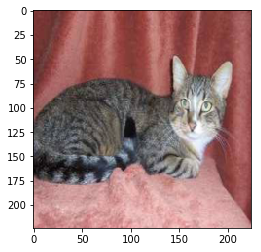

In [16]:
img = train_data[9][0]
imshow(img)

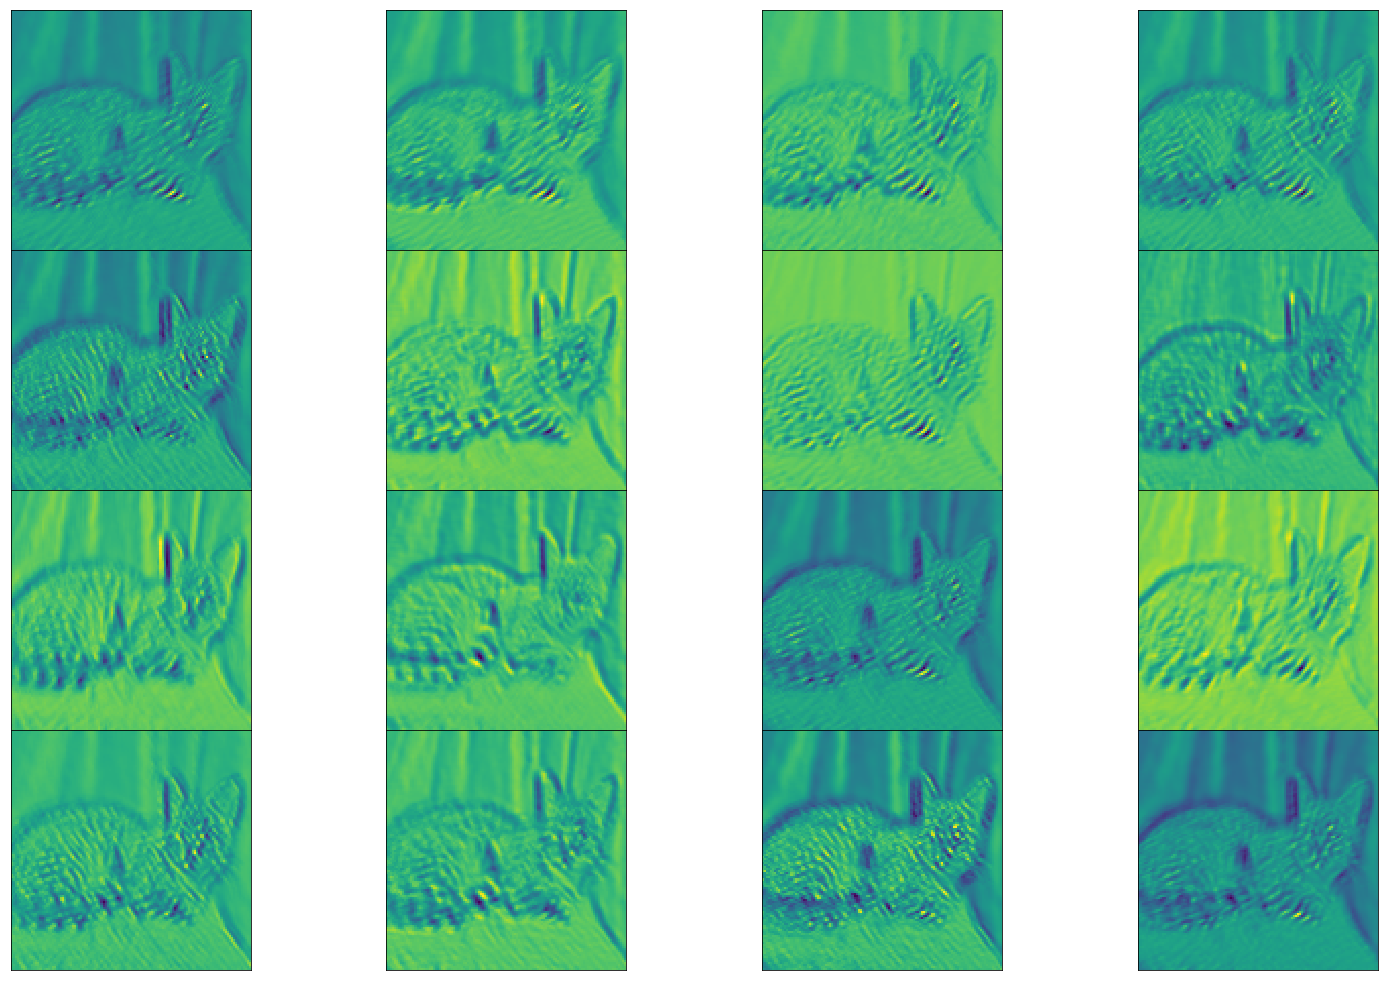

In [255]:
#得到句柄
conv_out = ActivationOutputData(model.conv2)
#传入图片
o = model(img.unsqueeze(0).cuda())
#移除回调函数
conv_out.remove()
fig = plt.figure(figsize=(20,50))
fig.subplots_adjust(left=0,right=1,bottom=0,top=0.8,hspace=0,wspace=0.2)
for i in range(16):
    ax = fig.add_subplot(12,4,i+1,xticks=[],yticks=[])
    ax.imshow(conv_out.outputs[0][i].detach().numpy())

In [256]:
#查看第一个卷积层

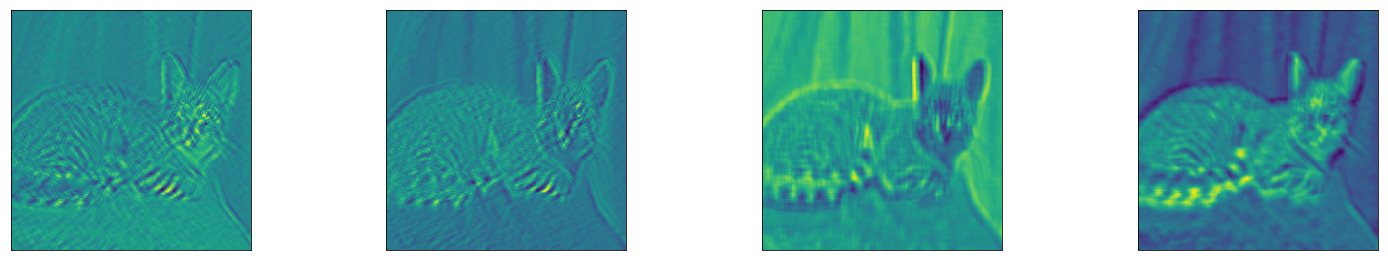

In [258]:
#得到句柄
conv_out = ActivationOutputData(model.conv1)
#传入图片
o = model(img.unsqueeze(0).cuda())
#移除回调函数
conv_out.remove()
fig = plt.figure(figsize=(20,50))
fig.subplots_adjust(left=0,right=1,bottom=0,top=0.8,hspace=0,wspace=0.2)
for i in range(4):
    ax = fig.add_subplot(12,4,i+1,xticks=[],yticks=[])
    ax.imshow(conv_out.outputs[0][i].detach().numpy())

In [259]:
#借助Vgg16实现迁移学习

In [7]:
from torchvision import models
vgg16 = models.vgg16(pretrained=True)
#冻结网络层
for param in vgg16.features.parameters(): 
    param.requires_grad = False
#微调网络
vgg16.classifier[6].out_features = 2
vgg16.cuda()

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (17): Conv2d

In [8]:
def vgg_train(args, vgg, device, dataloader_kwargs):
    #手动设置随机种子
    torch.manual_seed(args.get("seed")+1)
    #加载训练数据
    train_loader = torch.utils.data.DataLoader(args.get("train_data"),batch_size=args.get("batch_size"),num_workers=6,shuffle=True,**dataloader_kwargs)
    
    #使用随机梯度下降进行优化
    optimizer = optim.SGD(vgg.parameters(), lr=args.get("lr"), momentum=args.get("momentum"))
    #开始训练，训练epoches次
    for epoch in range(1, args.get("epochs") + 1):
        vgg_train_epoch(epoch, args, vgg, device, train_loader, optimizer)



def vgg_train_epoch(epoch, args, vgg, device, data_loader, optimizer):
    #模型转换为训练模式
    vgg.train()
    pid = os.getpid()
    for batch_idx, (data, target) in enumerate(data_loader):
        #优化器梯度置0
        optimizer.zero_grad()
        #输入特征预测值
        output = F.log_softmax(vgg(data.to(device)))
        #预测值与标准值计算损失
        loss = F.nll_loss(output.narrow(1,0,2),target.to(device))
        #计算梯度
        loss.backward()
        #更新梯度
        optimizer.step()
        #每10步打印一下日志
        if batch_idx % 10 == 0:
            print('{}\tTrain Epoch: {} [{}/{} ({:.2f}%)]\tLoss: {:.12f}'.format(pid, epoch, batch_idx * len(data), len(data_loader.dataset),
                                                                               100. * batch_idx / len(data_loader), loss.item()))

In [ ]:
from torchvision import models
import torch
import torch.nn as nn
import torch.nn.functional as F

import torch.optim as optim
from torchvision import datasets, transforms
import argparse
import os
torch.cuda.empty_cache()
#数据加载
from torchvision.datasets import ImageFolder
simple_transform = transforms.Compose([transforms.Resize((224,224))
                                       ,transforms.ToTensor()
                                       ,transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
                                      ])
train_data = ImageFolder('./DogVsCatData/train',simple_transform)
#用微调好的网络传入数据重新训练模型
#超参数及默认值
args={
    'batch_size':32,
    'epochs':10,
    'lr':0.0001,
    'momentum':0.5,
    'seed':1,
    'log_interval':30,
    'train_data':train_data
}
use_cuda=True if torch.cuda.is_available() else False

if __name__=="__main__":
    #运行时设备
    device = torch.device("cuda:0" if use_cuda else "cpu")
    vgg16 = models.vgg16(pretrained=True)
    
    #冻结网络层
    for param in vgg16.features.parameters(): 
        param.requires_grad = False
    #微调网络
    fc_features = vgg16.classifier[6].in_features  
    #修改类别为2
    vgg16.classifier[6] = nn.Linear(fc_features,2) 
    vgg16.cuda()
    #使用固定缓冲区
    dataloader_kwargs = {'pin_memory': True} if use_cuda else {}
    vgg_train(args,vgg16,device, dataloader_kwargs)

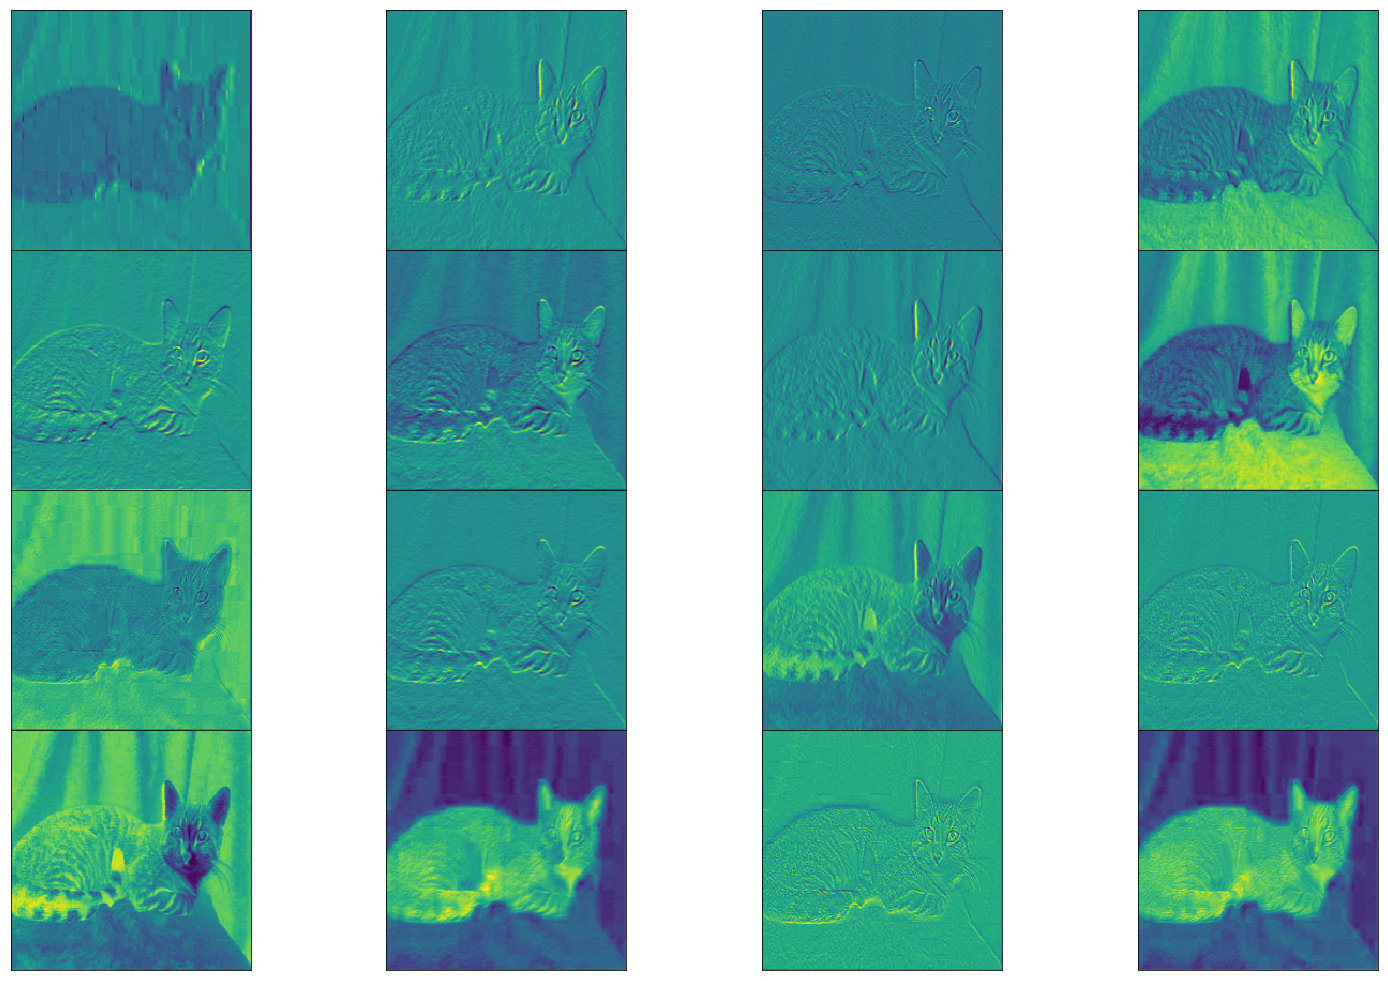

In [21]:
#得到句柄
conv_out = ActivationOutputData(vgg16.features[0])
#传入图片
o = vgg16(img.unsqueeze(0).cuda())
#移除回调函数
conv_out.remove()
fig = plt.figure(figsize=(20,50))
fig.subplots_adjust(left=0,right=1,bottom=0,top=0.8,hspace=0,wspace=0.2)
for i in range(16):
    ax = fig.add_subplot(12,4,i+1,xticks=[],yticks=[])
    ax.imshow(conv_out.outputs[0][i].detach().numpy())

In [23]:
vgg16.state_dict()

OrderedDict([('features.0.weight',
              tensor([[[[-5.5373e-01,  1.4270e-01,  5.2896e-01],
                        [-5.8312e-01,  3.5655e-01,  7.6566e-01],
                        [-6.9022e-01, -4.8019e-02,  4.8409e-01]],
              
                       [[ 1.7548e-01,  9.8630e-03, -8.1413e-02],
                        [ 4.4089e-02, -7.0323e-02, -2.6035e-01],
                        [ 1.3239e-01, -1.7279e-01, -1.3226e-01]],
              
                       [[ 3.1303e-01, -1.6591e-01, -4.2752e-01],
                        [ 4.7519e-01, -8.2677e-02, -4.8700e-01],
                        [ 6.3203e-01,  1.9308e-02, -2.7753e-01]]],
              
              
                      [[[ 2.3254e-01,  1.2666e-01,  1.8605e-01],
                        [-4.2805e-01, -2.4349e-01,  2.4628e-01],
                        [-2.5066e-01,  1.4177e-01, -5.4864e-03]],
              
                       [[-1.4076e-01, -2.1903e-01,  1.5041e-01],
                        [-8.4127e-01, -3

In [37]:
 vgg16.state_dict().keys()

odict_keys(['features.0.weight', 'features.0.bias', 'features.2.weight', 'features.2.bias', 'features.5.weight', 'features.5.bias', 'features.7.weight', 'features.7.bias', 'features.10.weight', 'features.10.bias', 'features.12.weight', 'features.12.bias', 'features.14.weight', 'features.14.bias', 'features.17.weight', 'features.17.bias', 'features.19.weight', 'features.19.bias', 'features.21.weight', 'features.21.bias', 'features.24.weight', 'features.24.bias', 'features.26.weight', 'features.26.bias', 'features.28.weight', 'features.28.bias', 'classifier.0.weight', 'classifier.0.bias', 'classifier.3.weight', 'classifier.3.bias', 'classifier.6.weight', 'classifier.6.bias'])

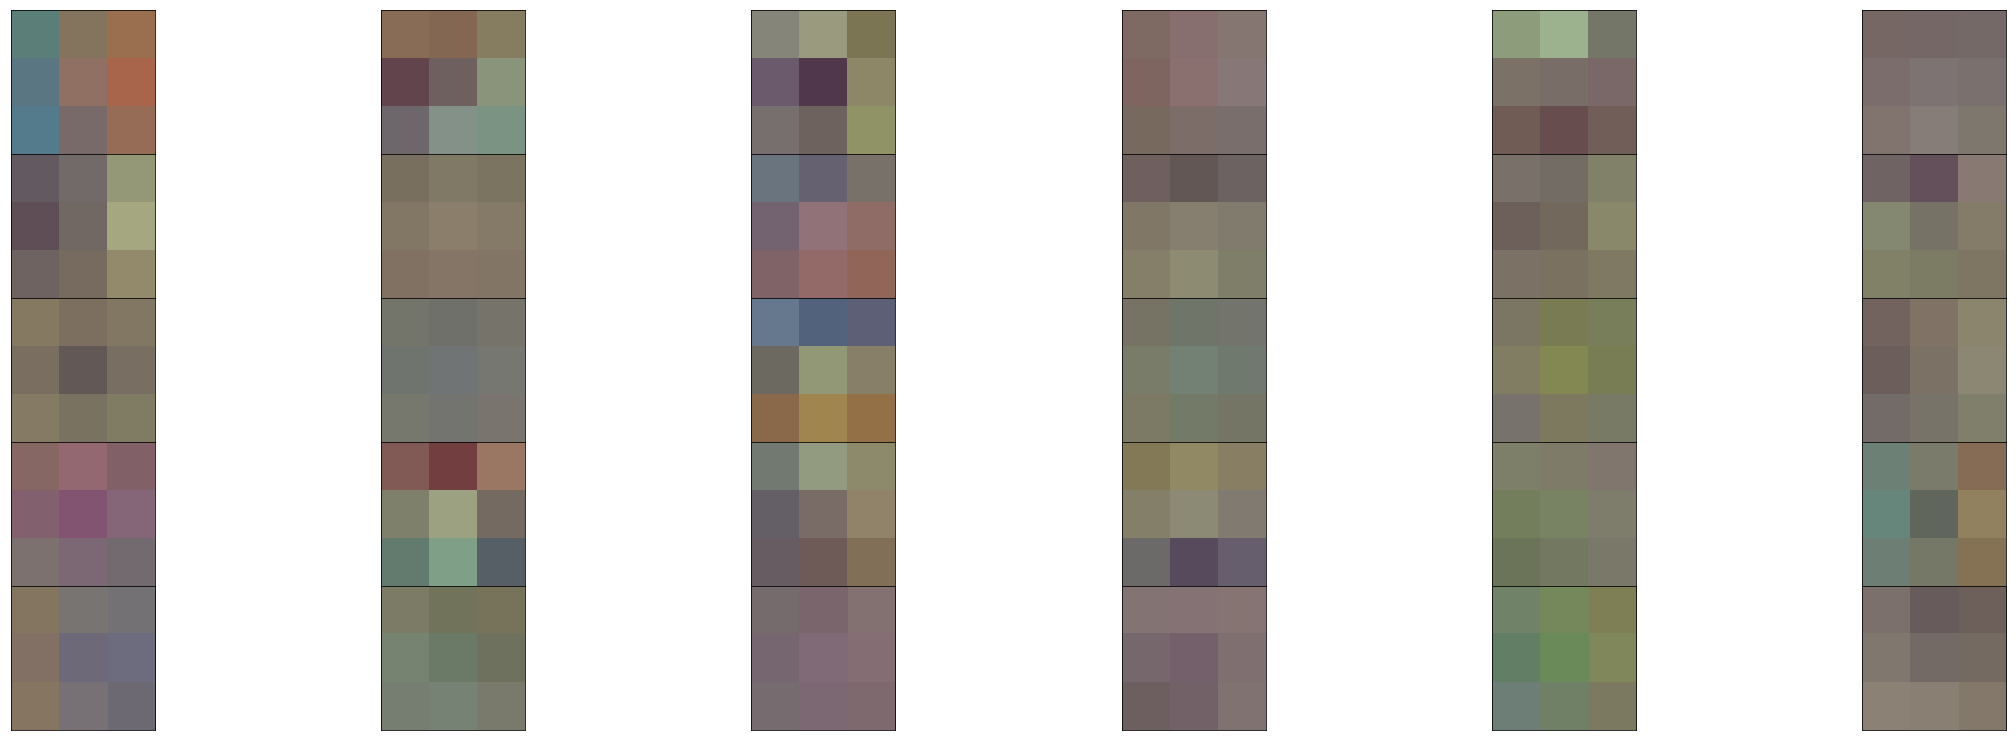

In [48]:
cnn_weights = vgg16.state_dict()['features.0.weight'].cpu()
fig = plt.figure(figsize=(30,30))
fig.subplots_adjust(left=0,right=1,bottom=0,top=0.8,hspace=0,wspace=0.2)
for i in range(30):
    ax = fig.add_subplot(12,6,i+1,xticks=[],yticks=[])
    imshow(cnn_weights[i])